## Load dataset

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

def prep_digits():
    """prepare digits in shape digit x h x w"""
    digits = load_digits()
    X = digits.data/255
    y = digits.target
    
    X_train, X_test, y_train, y_test = train_test_split(
                                        X, y, test_size=0.2, random_state=42)
    
    return X_train.reshape(-1,8,8), X_test.reshape(-1,8,8), y_train, y_test

In [14]:
X_train, X_test, y_train, y_test = prep_digits()

## Prep data loader

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(123)
torch.cuda.manual_seed_all(12345)

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image, target):
        return torch.from_numpy(image), torch.from_numpy(target)
                
class DataClass(Dataset):
    def __init__(self, X, y, transform=None):

        self.transform = transform
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        image = self.X[idx]
        target = self.y[idx]
        
        if self.transform:
            image, target = self.transform((image, target))
            
        return image, target

In [16]:
params = {"batch_size": 256, 
          "h_dim": 10,
          "z_dim": 20,
          "x_dim": X_train.shape[2],
          "learning_rate": 1e-3,
          "epochs": 1000,
          "kl_weight": 1e-3,
          "pre_trained": True,
         }

train_set = DataClass(X_train, y_train)
test_set = DataClass(X_train, y_train)

train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=params["batch_size"],
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                           batch_size=params["batch_size"],
                                           shuffle=False)

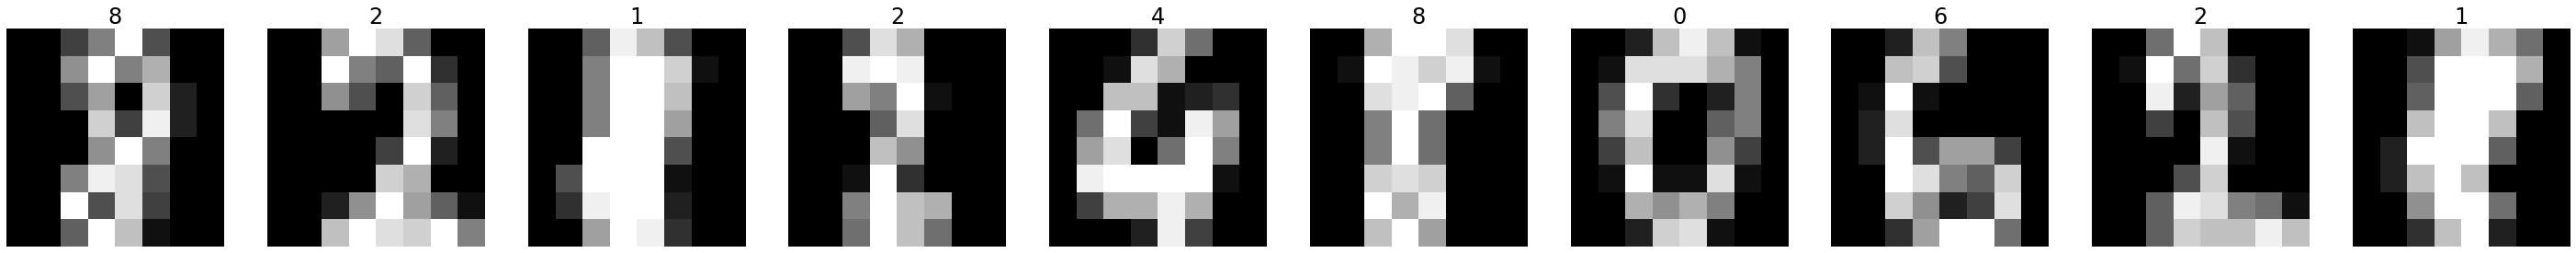

In [17]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = '20'

np.random.seed(42)
n_samples = 10
f, ax = plt.subplots(1,n_samples, figsize=(5 * n_samples, 5))
for i in range(n_samples):
    n = np.random.randint(len(train_set))
    
    img, target = train_set[n]
    
    ax[i].imshow(img, cmap="gray")
    ax[i].set_title(target)
    ax[i].axis("off")

plt.show()

## Model

In [18]:
from model import VRNN
from loss import loss_function
import torch.optim as optim

def predict_image(out, input, target, bce_loss=False, save_img=False):

    p_mus, p_sigmas, z_mus, z_sigmas, decoded = out
    n_samples = 10
    f, ax = plt.subplots(2, n_samples, figsize=(5 * n_samples, 10))
    for i in range(n_samples):
        
        n = np.random.randint(len(input))

        if "cuda" == device.type:

            if bce_loss:
                img = torch.sigmoid(decoded[n]).detach().cpu().numpy()
            else:
                img = decoded[n].detach().cpu().numpy()
        else:
            if bce_loss:
                img = torch.sigmoid(decoded[n]).detach().numpy()
            else:
                img = decoded[n].detach().numpy()

        ax[0,i].imshow(input[n].cpu().numpy(), cmap="gray")
        ax[1,i].imshow(img, cmap="gray")
        ax[0,i].set_title(target[n].numpy())
        ax[0,i].axis("off")
        ax[1,i].axis("off")
    
        if i == 0:
            ax[0,0].set(ylabel="True")
            ax[1,0].set(ylabel="Reconstructed")
    
    if save_img:
        plt.tight_layout()
        plt.savefig("reconstructed.png", dpi=300)
    
    plt.show()

5.868093450864156


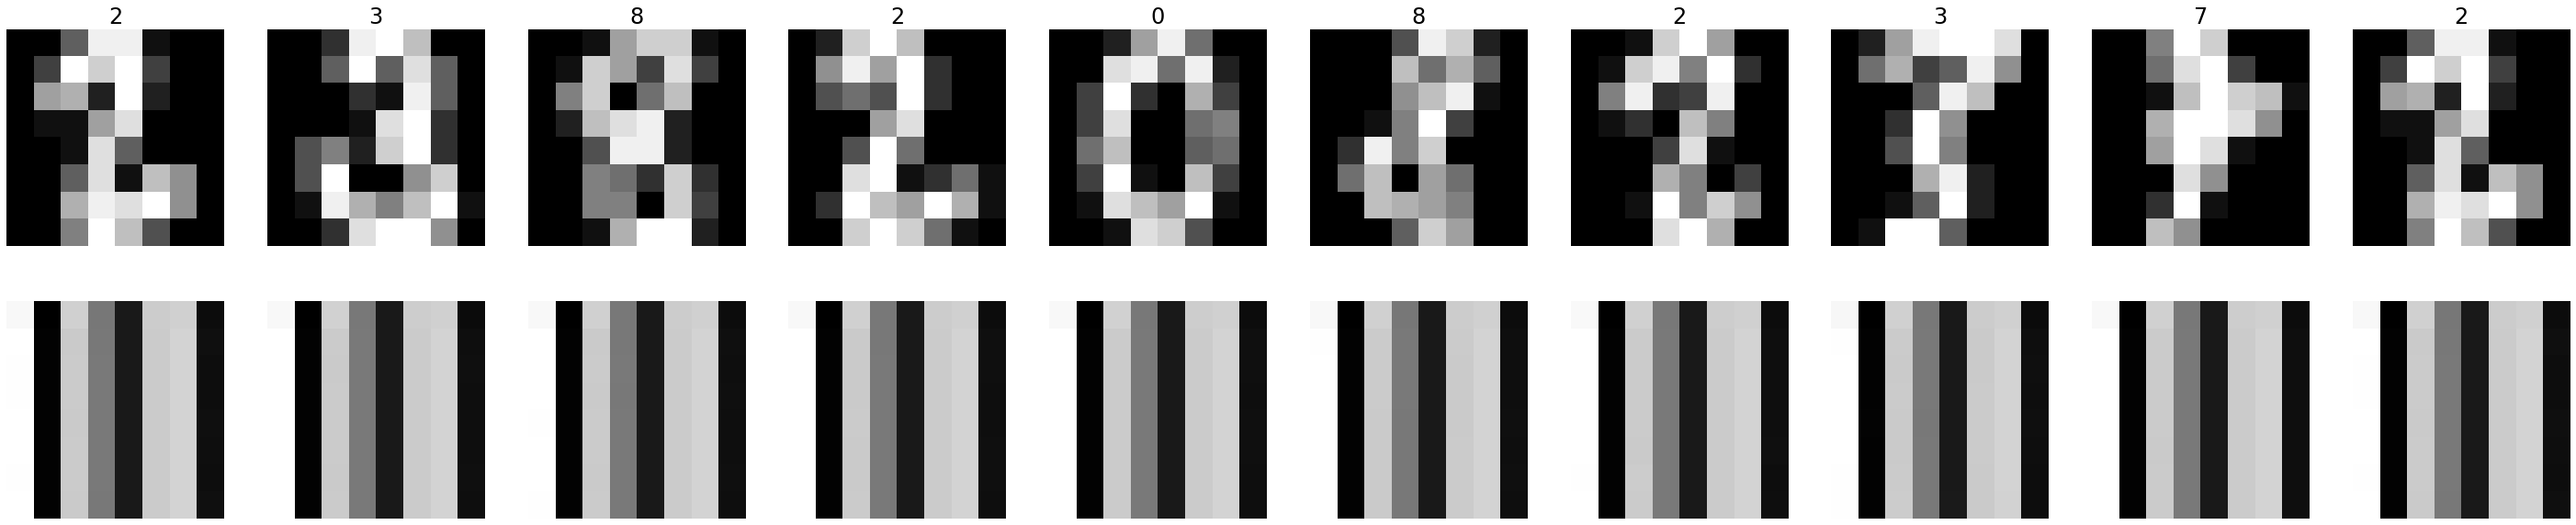

In [19]:
model = VRNN(params)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

model.to(device)

optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"])

epoch_loss = 0
for i, (data, target) in enumerate(train_loader):
    img = data.to(device, dtype=torch.float)
    out = model(img)
    
    loss,_,_ = loss_function(out, img, params)
    
    epoch_loss += loss.item()
    
print(epoch_loss / len(train_loader))

predict_image(out, img, target)

## train

In [20]:
def train(model, data_loader, params, phase, verbose=0):
    
    if phase != "train":
        model.eval()
    
    epoch_loss = 0
    rc_e_loss = 0
    kl_e_loss = 0
    
    for i, (data, target) in enumerate(data_loader):
        imgs = (data).to(device, dtype=torch.float)
        out = model(imgs)
        loss, rc_loss, kl_loss = loss_function(out, imgs, params)
        
        if phase == "train":
            model.zero_grad()
            loss.backward()
            optimizer.step()
        
        epoch_loss += loss.item()
        rc_e_loss += rc_loss.item()
        kl_e_loss += kl_loss.item()
    
    if phase != "train":
        model.train()
    
    if verbose:
        print(f"Test Loss: {epoch_loss / (params['batch_size'] * len(data_loader)):.5f}")
        print(f"KL Loss: {kl_e_loss / (params['batch_size'] * len(data_loader)):.5f}")
        print(f"RC Loss: {rc_e_loss / (params['batch_size'] * len(data_loader)):.5f}\n")

def main(model, train_loader, test_loader, params):
    
    for ep in range(1, params["epochs"] + 1):
        
        if (ep % 100) == 0:
            print(f"Epoch: {ep}/{params['epochs']}")
            train(model, train_loader, params, "train", verbose=1)
            train(model, test_loader, params, "eval", verbose=1)
        else:
            train(model, train_loader, params, "train", verbose=0)
              
    return model

In [21]:
if params["pre_trained"]:
    model.load_state_dict(torch.load('./pretrained.pth', map_location=device))
else:
    model = main(model, train_loader, test_loader, params)
    torch.save(model.state_dict(), './pretrained.pth')

## eval

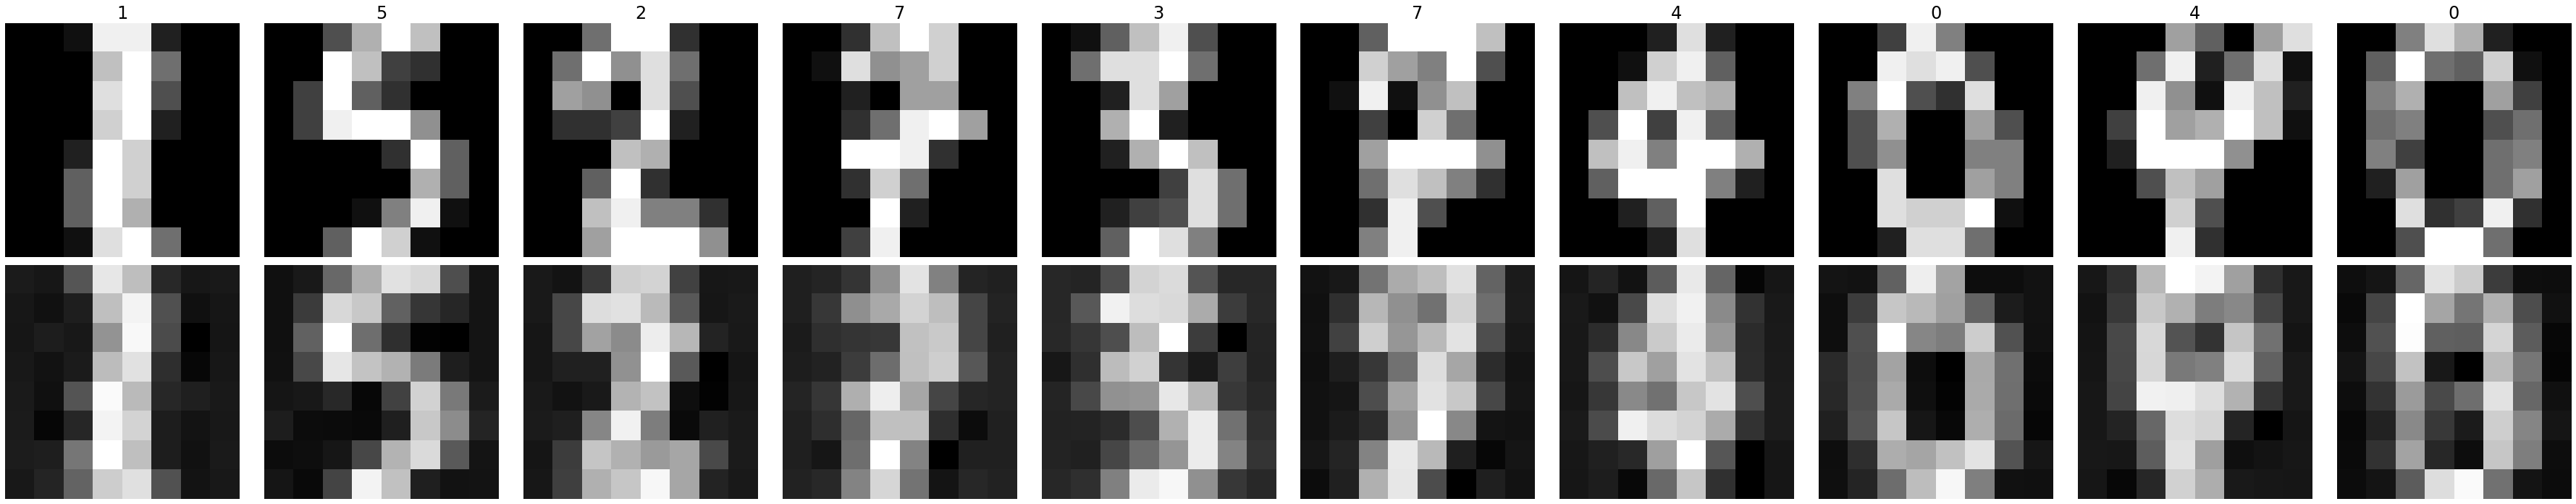

In [22]:
model.eval()

(data, target) = next(iter(test_loader))

imgs = (data).to(device, dtype=torch.float)
out = model(imgs)

predict_image(out, data, target, save_img=True)